## *Simulação* 

Simulação do protocolo E91 sem Eavesdrop

In [121]:
import numpy as np
import re
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, assemble, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
from qiskit.visualization import array_to_latex
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
from qiskit.primitives import StatevectorSampler

### *Passo 1: Criar os singlets*

No primeiro passo, Alice e Bob recebem os seus qubits dos estados singlet \(\lvert\psi_s\rangle\) criados por Charlie.

Para a nossa simulação, precisamos de registos com dois bits quânticos e quatro bits clássios.


In [280]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Vamos assumir que os qubits *qr\[0\]* e *qr\[1\]* pertencem a Alice e Bob, respetivamente.
Nos bits clássicos *cr\[0\]* e *cr\[1\]*, Alice e Bob armazenam os seus resultados de medição, enquanto os bits clássicos *cr\[2\]* e *cr\[3\]* são utilizados por Eve para armazenar os seus resultados de medição dos qubits de Alice e Bob.

Agora, Charlie cria um estado singlet:


In [282]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

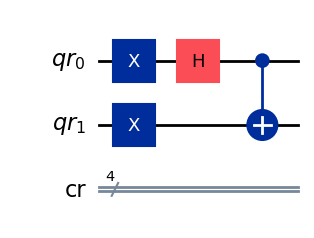

In [211]:
singlet.draw(output = 'mpl')

### *Passo 2: Medições*

Primeiro, vamos preparar as medições que serão utilizadas por Alice e Bob.  
Definimos$\(A(\vec{a}_i) = \vec{a}_i \cdot \vec{\sigma}\) e \(B(\vec{b}_j) = \vec{b}_j \cdot \vec{\sigma}\$) como os observáveis de projeção do spin utilizados por Alice e Bob para as suas medições.  
Para realizar estas medições, a base padrão \(Z\) deve ser rodada para a base adequada sempre que necessário.


Os blocos no lado esquerdo podem ser considerados como *detetores* utilizados pelos participantes para medir os observáveis \(X, W, Z\) e \(V\).  
Agora preparamos os circuitos correspondentes.


In [284]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

## Bob's measurement circuits

# measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

In [286]:
# Define the number of singlets N
numberOfSinglets = 500

Os participantes devem escolher as direções nas quais irão medir as projeções de spin dos seus qubits.  
Para isso, Alice e Bob criam as sequêncis e) com elementos gerados aleatoriamente.


In [288]:
aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b of Alice
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b' of Bob

(singlet + Alice's measurement + Bob's measurement).

In [290]:
circuits = [] # the list in which the created circuits will be stored

for i, (alice_choice, bob_choice) in enumerate(zip(aliceMeasurementChoices, bobMeasurementChoices)):
    circuit = singlet.copy()
    circuit.compose(aliceMeasurements[alice_choice - 1], inplace=True)
    circuit.compose(bobMeasurements[bob_choice - 1], inplace=True)
    
    # Atribuir um nome único ao circuito
    circuit.name = f"singlet_{i}_A{alice_choice}_B{bob_choice}"
    circuits.append(circuit)

In [292]:
print(circuits[0].name)

singlet_0_A3_B1


### *Passo 3: Calcular os Resultados*

In [57]:
backend=Aer.get_backend('qasm_simulator')
job = backend.run(circuits)  
#print(result) # uncomment for detailed result

In [59]:
result = job.result()
result.get_counts(circuits[0])

{'0000': 252, '0011': 254, '0010': 248, '0001': 270}

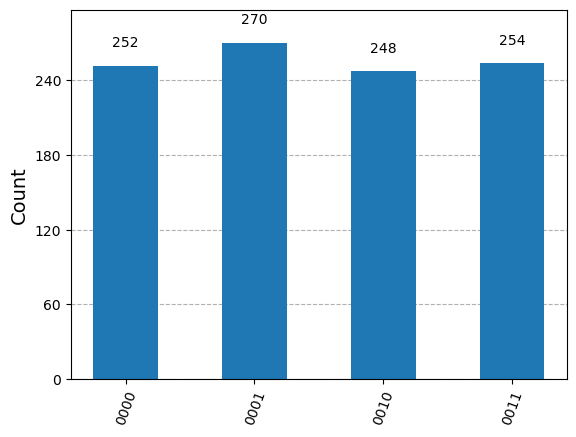

In [61]:
plot_histogram(result.get_counts(circuits[0]))

Consiste em quatro dígitos.  
Recorda que Alice e Bob armazenam os resultados da medição nos bits clássicos *cr\[0\]* e *cr\[1\]* (dois dígitos à direita).  
Como estamos a modelar o processo de geração de uma chave secreta sem a presença de um intruso, os bits clássicos *cr\[2\]* e *cr\[3\]* são sempre 0.  
Nota também que a saída é um dicionário Python, no qual as chaves são os resultados obtidos e os valores são as contagens.

Alice e Bob registam os resultados das suas medições como bits das sequências \(a\) e \(a^{'}\).


In [63]:
abPatterns = [
    re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('..01$'), # search for the '..01' output
    re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('..11$')  # search for the '..11' output
]

In [65]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

for i in range(numberOfSinglets):

    res = list(result.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

### *Passo 4: Revelar as Bases*

No passo anterior, armazenámos os resultados das medições de Alice e Bob nas listas *aliceResults* e *bobResults* (sequências \(a\) e \(a^{'}\)).  
Agora, os participantes comparam as suas sequências \(b\) e \(b^{'}\) através do canal clássico público.  
Se Alice e Bob tiverem medido as projeções de spin dos seus qubits do singlet \(i\)-ésimo na mesma direção, então Alice regista o resultado \(a_i\) como o bit da sequência \(k\), e Bob regista o resultado \(-a_i\) como o bit da sequência \(k^{'}\) (ver Eq. (1)).


In [67]:
aliceKey = [] # Alice's key string k
bobKey = [] # Bob's key string k'

# comparing the stings with measurement choices
for i in range(numberOfSinglets):
    # if Alice and Bob have measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
        aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(- bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        
keyLength = len(aliceKey) # length of the secret key

In [69]:
abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

### *Passo 5: Teste do valor de correlação*

Alice e Bob querem garantir que a comunicação foi segura e sem interferências. Para isso, utilizam os resultados das medições realizadas nas suas qubits, analisando as correlações das projeções de spin em diferentes direções. Estas correlações, baseadas nas probabilidades de resultados específicos, são usadas para calcular o valor CHSH, que permite verificar se houve entrelaçamento quântico.

Se o valor CHSH for maior que 2, confirma-se o entrelaçamento e, portanto, a segurança da comunicação. Este cálculo é feito com base nos dados revelados por Alice e Bob sobre as medições realizadas e os resultados obtidos.

In [71]:
# function that calculates CHSH correlation value
def chsh_corr(result):
    
    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    countA1B1 = [0, 0, 0, 0] # XW observable
    countA1B3 = [0, 0, 0, 0] # XV observable
    countA3B1 = [0, 0, 0, 0] # ZW observable
    countA3B3 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    # number of the results obtained from the measurements in a particular basis
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    # expectation values of XW, XV, ZW and ZV observables (2)
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 # -1/sqrt(2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # 1/sqrt(2)
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 # -1/sqrt(2)
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 # -1/sqrt(2) 
    
    corr = expect11 - expect13 + expect31 + expect33 # calculate the CHSC correlation value (3)
    
    return corr

### *Resultado*

In [73]:
corr = chsh_corr(result) # CHSH correlation value

# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)))

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

CHSH correlation value: -2.671
Length of the key: 237
Number of mismatching bits: 0



Finalmente, Alice e Bob possuem as chaves secretas \(k\) e \(k^{'}\) (*aliceKey* e *bobKey*)!  
Agora podem utilizar a técnica de one-time pad para cifrar e decifrar mensagens.

Como estamos a simular o protocolo E91 sem a presença de Eve, o valor de correlação CHSH deve ser próximo de \(-2\sqrt{2} \approx -2.828\).  
Além disso, não deve haver discrepâncias nos bits das chaves de Alice e Bob.  

Nota que existem 9 combinações possíveis de medições que podem ser realizadas por Alice e Bob, mas apenas 2 destas produzem resultados que permitem a criação das chaves secretas.  
Por isso, a razão entre o comprimento das chaves e o número de singlets \(N\) deve ser aproximadamente \(2/9\).


## *Simulação de eavesdropping*

Suponhamos que um terceiro, Eve, pretende interferir na sessão de comunicação de Alice e Bob para obter a chave secreta.  
Eve pode usar ataques de *intercept-resend*: ela intercepta um ou ambos os qubits entrelaçados preparados por Charlie, mede as projeções de spin, cria novos qubits com base nos resultados (\(\lvert 01 \rangle\) ou \(\lvert 10 \rangle\)) e envia-os a Alice e Bob.  

Eve deve escolher as direções das medições como \(\vec{n}_A = \vec{a}_2, \vec{a}_3\) e \(\vec{n}_B = \vec{b}_1, \vec{b}_2\), pois apenas os resultados destas direções podem ser usados para criar uma chave secreta.

Agora preparamos os circuitos para as medições de Eve.
Eve.


In [77]:
# measurement of the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Allice's qubit onto the a_3 direction (standard Z basis)
measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z measurement)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

Assim como Alice e Bob, Eve deve escolher as direções nas quais irá medir as projeções de spin dos qubits.  
Na nossa simulação, a intrusa escolhe aleatoriamente um dos observáveis. $W \otimes W$ or $Z \otimes Z$ para medir.

In [79]:
# list of Eve's measurement choices
# the first and the second elements of each row represent the measurement of Alice's and Bob's qubits by Eve respectively
eveMeasurementChoices = []

for j in range(numberOfSinglets):      
    if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the WW measurement
        eveMeasurementChoices.append([0, 2])
    else: # in 50% of cases perform the ZZ measurement
        eveMeasurementChoices.append([1, 3])

In [83]:
circuits = []  # Lista onde os circuitos criados serão armazenados

for j in range(numberOfSinglets):
    # Criar o nome único do j-ésimo circuito, dependendo das escolhas de medição de Alice, Bob e Eve
    circuitName = f"{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j] + 2}_E{eveMeasurementChoices[j][0]}{eveMeasurementChoices[j][1] - 1}"
    
    # Criar uma cópia do circuito singlet para preservar o original
    jointCircuit = singlet.copy()
    
    # Adicionar os circuitos de medição de Eve
    jointCircuit.compose(eveMeasurements[eveMeasurementChoices[j][0] - 1], inplace=True)
    jointCircuit.compose(eveMeasurements[eveMeasurementChoices[j][1] - 1], inplace=True)
    
    # Adicionar os circuitos de medição de Alice
    jointCircuit.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1], inplace=True)
    
    # Adicionar os circuitos de medição de Bob
    jointCircuit.compose(bobMeasurements[bobMeasurementChoices[j] - 1], inplace=True)
    
    # Adicionar o circuito criado à lista de circuitos
    circuits.append(jointCircuit)


In [103]:
# Selecionar o simulador
backend = Aer.get_backend('qasm_simulator')
# Executar os circuitos
transpiled_circuits = [transpile(circuit, backend) for circuit in circuits]
job = backend.run(transpiled_circuits, shots=1)
result = job.result()

# Obter e processar os resultados
for j in range(len(circuits)):
    res = list(result.get_counts(j).keys())[0]  # Acessar pelo índice
    print(f"Circuit_{j}: {res}")


Circuito 0: 1010
Circuito 1: 1010
Circuito 2: 1010
Circuito 3: 1010
Circuito 4: 0100
Circuito 5: 0101
Circuito 6: 1010
Circuito 7: 1000
Circuito 8: 0111
Circuito 9: 1010
Circuito 10: 1010
Circuito 11: 0100
Circuito 12: 1010
Circuito 13: 1000
Circuito 14: 1010
Circuito 15: 1001
Circuito 16: 1010
Circuito 17: 0100
Circuito 18: 1010
Circuito 19: 1010
Circuito 20: 1010
Circuito 21: 1010
Circuito 22: 1010
Circuito 23: 1011
Circuito 24: 0101
Circuito 25: 1010
Circuito 26: 0101
Circuito 27: 0101
Circuito 28: 0101
Circuito 29: 0101
Circuito 30: 1010
Circuito 31: 0100
Circuito 32: 1010
Circuito 33: 1010
Circuito 34: 1010
Circuito 35: 0101
Circuito 36: 1011
Circuito 37: 1010
Circuito 38: 1010
Circuito 39: 0101
Circuito 40: 0100
Circuito 41: 1010
Circuito 42: 1010
Circuito 43: 1010
Circuito 44: 0101
Circuito 45: 1010
Circuito 46: 0101
Circuito 47: 0101
Circuito 48: 0101
Circuito 49: 1010
Circuito 50: 0101
Circuito 51: 1001
Circuito 52: 1010
Circuito 53: 1010
Circuito 54: 0111
Circuito 55: 1010
Ci

In [93]:
# Criar circuitos com nomes únicos
for i, circuit in enumerate(circuits):
    circuit.name = f"circuit_{i}"

# Obter e imprimir os resultados
for i, circuit in enumerate(circuits):
    counts = result.get_counts(i)  # Usar o índice para acessar os resultados
    print(f"{circuit.name}\t{counts}")

circuit_0	{'0101': 1}
circuit_1	{'0101': 1}
circuit_2	{'1010': 1}
circuit_3	{'0101': 1}
circuit_4	{'0100': 1}
circuit_5	{'1010': 1}
circuit_6	{'1011': 1}
circuit_7	{'0111': 1}
circuit_8	{'0101': 1}
circuit_9	{'0101': 1}
circuit_10	{'0101': 1}
circuit_11	{'0100': 1}
circuit_12	{'0101': 1}
circuit_13	{'1010': 1}
circuit_14	{'0101': 1}
circuit_15	{'0101': 1}
circuit_16	{'0100': 1}
circuit_17	{'1010': 1}
circuit_18	{'0101': 1}
circuit_19	{'1010': 1}
circuit_20	{'0101': 1}
circuit_21	{'1011': 1}
circuit_22	{'1010': 1}
circuit_23	{'1010': 1}
circuit_24	{'0101': 1}
circuit_25	{'1010': 1}
circuit_26	{'1010': 1}
circuit_27	{'0101': 1}
circuit_28	{'0111': 1}
circuit_29	{'1010': 1}
circuit_30	{'1010': 1}
circuit_31	{'0101': 1}
circuit_32	{'0101': 1}
circuit_33	{'1010': 1}
circuit_34	{'1010': 1}
circuit_35	{'1011': 1}
circuit_36	{'1010': 1}
circuit_37	{'1010': 1}
circuit_38	{'1010': 1}
circuit_39	{'1010': 1}
circuit_40	{'0100': 1}
circuit_41	{'1010': 1}
circuit_42	{'1010': 1}
circuit_43	{'1010': 1

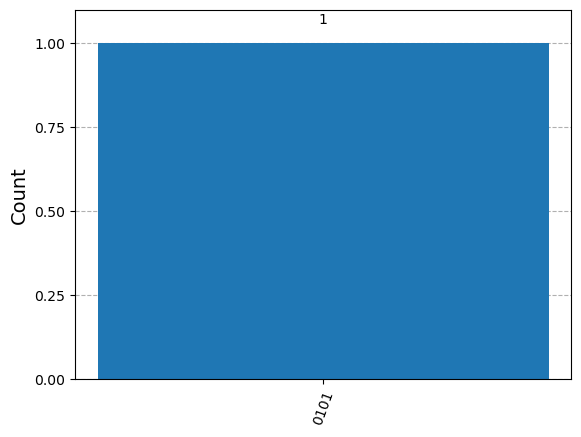

In [97]:
plot_histogram(result.get_counts(0))

In [99]:
ePatterns = [
    re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
    re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
    re.compile('10..$'),
    re.compile('11..$')  
]

In [105]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

# list of Eve's measurement results
# the elements in the 1-st column are the results obtaned from the measurements of Alice's qubits
# the elements in the 2-nd column are the results obtaned from the measurements of Bob's qubits
eveResults = [] 

# recording the measurement results
for j in range(numberOfSinglets):
    
    res = list(result.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
    
    # Alice and Bob
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

    # Eve
    if ePatterns[0].search(res): # check if the key is '00..'
        eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
    if ePatterns[1].search(res):
        eveResults.append([1, -1])
    if ePatterns[2].search(res):
        eveResults.append([-1, 1])
    if ePatterns[3].search(res):
        eveResults.append([1, 1])
        

In [107]:
aliceKey = [] # Alice's key string a
bobKey = [] # Bob's key string a'
eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

# comparing the strings with measurement choices (b and b')
for j in range(numberOfSinglets):
    # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):  
        aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve 

keyLength = len(aliceKey) # length of the secret skey

In [109]:
abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]: 
        abKeyMismatches += 1
    if eveKeys[j][0] != aliceKey[j]:
        eaKeyMismatches += 1
    if eveKeys[j][1] != bobKey[j]:
        ebKeyMismatches += 1

In [111]:
eaKnowledge = (keyLength - eaKeyMismatches)/keyLength # Eve's knowledge of Bob's key
ebKnowledge = (keyLength - ebKeyMismatches)/keyLength # Eve's knowledge of Alice's key

In [113]:
corr = chsh_corr(result)

In [115]:
# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

CHSH correlation value: -1.724

Length of the key: 237
Number of mismatching bits: 28

Eve's knowledge of Alice's key: 92.83 %
Eve's knowledge of Bob's key: 92.83 %


Devido à interferência de Eve na sessão de comunicação, o valor de correlação CHSH fica muito distante de \(-2\sqrt{2}\).  
Alice e Bob percebem isso e decidem não usar a chave secreta para cifrar e decifrar mensagens.  

Ekert demonstrou que, independentemente da estratégia de espionagem de Eve e das direções \(\vec{n}_A\) e \(\vec{n}_B\) nas quais ela mede as projeções de spin dos qubits de Alice e Bob, pode-se escrever a seguinte desigualdade:

$$ -\sqrt{2} \leqslant C \leqslant \sqrt{2}, $$
oe \(C\) é o valor de correlaç\((3)\).  
Quanto mais Eve interfere na sessão, mais ela sabe sobre as chaves secretas, mas também maior é o desvio do  correlacao chsh{2}\).  

Os erros nas chaves de Alice e Bob surgem porque, ao medir os qubits do estad \rangle\), Eve obtém aleatoriamente os rult1s \(,1\)u \(1,-1\).  
Dependendo dos resultados, Eve cria \rangle\) (na simulação, isso é automaticamente feito pela medi  base \(Z\)) e envia os qubits para Alice e Bob.  

Quando Alice e Bob medemW \otimes W\), obtêm combinações _i, b_j)\).  
Isso pode ser comparado executando os códigos quânticos indicados parimes Z_B\).  

Para corrigir os erros nas chaves de Alice e Bob, são utilizados algoritmos de reconciliação de errant-ph/0101098)).


# Real Hardware

In [125]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

In [223]:
TOKEN = '3f81f5b538f53a8839848d4afa2cc15c382f7d203cfd03f9a6a8219b64d8a186de377fa9c7dc230efcdd2002916d4e0911f1ea183fa54c376cef994180842e63'
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(backend)
print(backend)

<IBMBackend('ibm_kyiv')>


In [296]:
# Transpile circuits for the chosen backend
transpiled_circuits = [transpile(circuit, backend=backend, optimization_level=1) for circuit in circuits]


In [298]:
# Executar no backend real
job = sampler.run(transpiled_circuits, shots=1024)
result = job.result()

In [233]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1, num_bits=4>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(cr=BitArray(<shap

In [157]:
!pip install bitstring

   ---------------------------------------- 0.0/71.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/71.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/71.9 kB ? eta -:--:--
   ---------------------- ----------------- 41.0/71.9 kB ? eta -:--:--
   ---------------------------------- ----- 61.4/71.9 kB 648.1 kB/s eta 0:00:01
   ---------------------------------------- 71.9/71.9 kB 560.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/121.5 kB ? eta -:--:--
   --------- ----------------------------- 30.7/121.5 kB 640.0 kB/s eta 0:00:01
   ------------- ------------------------- 41.0/121.5 kB 487.6 kB/s eta 0:00:01
   ------------------- ------------------- 61.4/121.5 kB 544.7 kB/s eta 0:00:01
   ------------------- ------------------- 61.4/121.5 kB 544.7 kB/s eta 0:00:01
   ----------------------------- --------- 92.2/121.5 kB 401.6 kB/s eta 0:00:01
   ----------------------------------- -- 112.6/121.5 kB 409.6 kB/s eta 0:00:01
   ----

In [167]:
from bitstring import BitArray
from qiskit.primitives import PrimitiveResult

In [266]:
job = service.job('cy772e97v8tg008fgw60')
result = job.result()

In [300]:
from collections import Counter

# Number of classical bits (e.g., 4 for your setup)
num_bits = 2
# Analyze results from PrimitiveResult
for i, circuit in enumerate(circuits):
    # Access the DataBin for each circuit result
    data_bin = result[i].data

    # Extract the BitArray from the 'cr' attribute
    bit_array = data_bin.cr

    # Convert the BitArray to a readable binary format
    binary_results = bit_array.array

    # Convert each shot result to a binary string
    bitstrings = [
        format(int(decimal_outcome), f"0{num_bits}b") for decimal_outcome in binary_results
    ]

    # Count occurrences of each binary bitstring
    counts = Counter(bitstrings)

    # Display results for this circuit
    print(f"Circuit: {circuit.name}")
    print(f"Counts: {dict(counts)}")
    print("-" * 40)


C:\Users\leole\AppData\Local\Temp\ipykernel_31792\1517315417.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  format(int(decimal_outcome), f"0{num_bits}b") for decimal_outcome in binary_results


Circuit: singlet_0_A3_B1
Counts: {'10': 467, '01': 389, '11': 91, '00': 77}
----------------------------------------
Circuit: singlet_1_A3_B1
Counts: {'00': 83, '01': 416, '10': 460, '11': 65}
----------------------------------------
Circuit: singlet_2_A1_B2
Counts: {'01': 255, '10': 242, '11': 264, '00': 263}
----------------------------------------
Circuit: singlet_3_A2_B3
Counts: {'10': 241, '11': 258, '00': 275, '01': 250}
----------------------------------------
Circuit: singlet_4_A3_B3
Counts: {'10': 429, '01': 418, '00': 79, '11': 98}
----------------------------------------
Circuit: singlet_5_A3_B1
Counts: {'10': 449, '00': 69, '01': 424, '11': 82}
----------------------------------------
Circuit: singlet_6_A3_B3
Counts: {'10': 440, '01': 407, '11': 86, '00': 91}
----------------------------------------
Circuit: singlet_7_A3_B3
Counts: {'10': 459, '00': 76, '01': 413, '11': 76}
----------------------------------------
Circuit: singlet_8_A2_B3
Counts: {'11': 269, '10': 227, '01'

In [302]:
from collections import Counter

# Helper function to calculate correlation
def calculate_correlation(counts, total_shots):
    """
    Calculate correlation from measurement counts.
    """
    p_00 = counts.get('00', 0) / total_shots
    p_01 = counts.get('01', 0) / total_shots
    p_10 = counts.get('10', 0) / total_shots
    p_11 = counts.get('11', 0) / total_shots
    return (p_00 + p_11) - (p_01 + p_10)

# Analyze results with basis matching
alice_results = []  # Alice's outcomes
bob_results = []    # Bob's outcomes
mismatches = 0      # Count mismatches in compatible bases
correlations = []   # Store correlations for CHSH test

# Iterate over circuits and evaluate mismatches
for i, circuit in enumerate(circuits):
    # Access the DataBin object
    data_bin = result[i].data

    # Extract the BitArray from the 'cr' attribute
    bit_array = data_bin.cr

    # Convert the BitArray to binary results
    binary_results = bit_array.array
    bitstrings = [
        format(int(outcome), f"0{num_bits}b") for outcome in binary_results
    ]

    # Count occurrences of each bitstring
    counts = Counter(bitstrings)

    # Total shots
    total_shots = sum(counts.values())

    # Extract Alice and Bob's bases and outcomes (mock data for now)
    alice_base = aliceMeasurementChoices[i]
    bob_base = bobMeasurementChoices[i]

    # Only compare compatible bases (example: 2 & 1, 3 & 2)
    if (alice_base, bob_base) in [(2, 1), (3, 2)]:
        # Analyze mismatches
        for outcome in bitstrings:
            alice_outcome = int(outcome[0])
            bob_outcome = int(outcome[1])
            alice_results.append(alice_outcome)
            bob_results.append(bob_outcome)

            # Check for mismatches
            if alice_outcome != bob_outcome:
                mismatches += 1

    # Calculate correlation for CHSH test
    correlation = calculate_correlation(counts, total_shots)
    correlations.append(correlation)

    # Debug: Print results
    print(f"Circuit: {circuit.name}")
    print(f"Counts: {dict(counts)}")
    print(f"Correlation: {correlation:.4f}")
    print("-" * 40)

# Calculate CHSH value
chsh_value = abs(correlations[0] - correlations[1] + correlations[2] + correlations[3])
print(f"CHSH Value: {chsh_value:.4f}")

# Evaluate mismatches and agreement rate
total_key_bits = len(alice_results)
agreement_rate = 1 - (mismatches / total_key_bits) if total_key_bits > 0 else 0

# Output results
print(f"Total Key Bits: {total_key_bits}")
print(f"Agreement Rate: {agreement_rate:.4f}")
print(f"Mismatches: {mismatches}")

# Determine entanglement
if chsh_value > 2:
    print("Entanglement confirmed (CHSH > 2).")
else:
    print("No evidence of entanglement (CHSH <= 2).")


C:\Users\leole\AppData\Local\Temp\ipykernel_31792\4030059791.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  format(int(outcome), f"0{num_bits}b") for outcome in binary_results


Circuit: singlet_0_A3_B1
Counts: {'10': 467, '01': 389, '11': 91, '00': 77}
Correlation: -0.6719
----------------------------------------
Circuit: singlet_1_A3_B1
Counts: {'00': 83, '01': 416, '10': 460, '11': 65}
Correlation: -0.7109
----------------------------------------
Circuit: singlet_2_A1_B2
Counts: {'01': 255, '10': 242, '11': 264, '00': 263}
Correlation: 0.0293
----------------------------------------
Circuit: singlet_3_A2_B3
Counts: {'10': 241, '11': 258, '00': 275, '01': 250}
Correlation: 0.0410
----------------------------------------
Circuit: singlet_4_A3_B3
Counts: {'10': 429, '01': 418, '00': 79, '11': 98}
Correlation: -0.6543
----------------------------------------
Circuit: singlet_5_A3_B1
Counts: {'10': 449, '00': 69, '01': 424, '11': 82}
Correlation: -0.7051
----------------------------------------
Circuit: singlet_6_A3_B3
Counts: {'10': 440, '01': 407, '11': 86, '00': 91}
Correlation: -0.6543
----------------------------------------
Circuit: singlet_7_A3_B3
Counts: